In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'src')

In [2]:
# import stlcg
import stlcg_agm as stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [4]:
t = t = np.arange(-3, 3, 0.2, dtype=np.float32)
x_np = 0.5 * np.exp(-t**2).reshape([1, t.shape[0], 1])
w_np = (0.4*np.exp(-(t + 0.5)**2) + 0.2*np.exp(-(t - 3)**2)).reshape([1, t.shape[0], 1])

x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(0.9, dtype=torch.float, requires_grad=True)

# Signal convolutional logic

In [5]:
ϕa = stlcg.Integral1d(subformula=stlcg.Identity(), padding_type="zero")
ϕb = stlcg.Integral1d(subformula=stlcg.Identity(), interval=[0, 5], padding_type="zero")
ϕc = stlcg.Integral1d(subformula=stlcg.Identity(), interval=[2, 5], padding_type="zero")
ϕd = stlcg.Always(subformula=stlcg.Identity(), interval=[0, 5])
ϕe = stlcg.Always(subformula=stlcg.Identity(), interval=[2, 5])

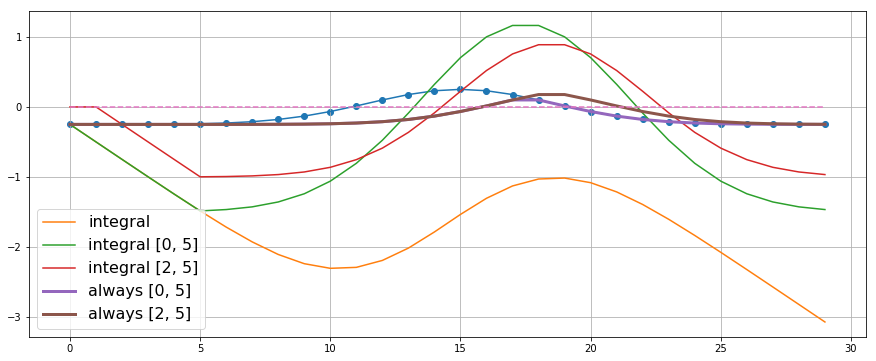

In [6]:
dt = 1.0
signal = x - 0.25
bsignal = 1.0*(signal > 0)
mask = torch.ones(signal.shape)
mask *= 2
mask[:,0,:] -= 1
mask[:,-1,:] -= 1
mask *= dt/2
p = 5
plt.figure(figsize=(15,6))

plt.plot(range(len(signal.squeeze())), signal.squeeze().numpy())
plt.scatter(range(len(signal.squeeze())), signal.squeeze().numpy())

plt.plot(range(len(signal.squeeze())), ϕa(signal).squeeze().numpy(), label="integral")
plt.plot(range(len(signal.squeeze())), ϕb(signal).squeeze().numpy(), label="integral [0, 5]")
plt.plot(range(len(signal.squeeze())), ϕc(signal).squeeze().numpy(), label="integral [2, 5]")
plt.plot(range(len(signal.squeeze())), ϕd(signal).squeeze().numpy(), linewidth=3, label="always [0, 5]")
plt.plot(range(len(signal.squeeze())), ϕe(signal).squeeze().numpy(), linewidth=3, label="always [2, 5]")

plt.plot([0, len(signal.squeeze())-1], [0, 0], "--")
plt.legend(fontsize=16)
plt.grid()

In [89]:
obs_1 = torch.tensor([-0.5, 0.5, 0.5, 0.75]).float()     # red box in bottom right corner
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression(obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression(obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression(obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression(u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

In [142]:
dx = 0.06
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = np.array([-1.0, 1.0])
xf = np.ones(2)
N = n.shape

u_max = torch.as_tensor(1.0).float()       # u max


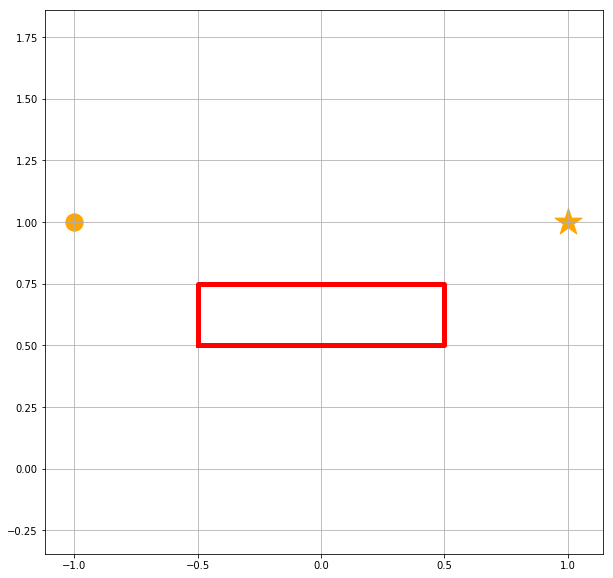

In [143]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="orange")
plt.scatter(*xf, s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()


In [144]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


In [178]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

In [179]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 10
inside_box_1, _ = inside_box(X, obs_1)
ϕ1 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_1, interval=[0,T], padding_type="same", custom_number=0.1))
ϕ2 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_1, interval=[0,T]))

θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

# robustness_1 = torch.relu(-ϕ1.robustness(box_inputs, scale=-1).squeeze())
# robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

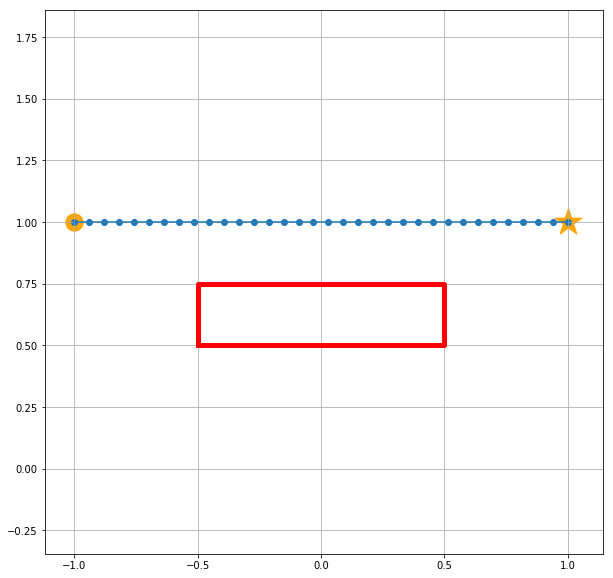

In [180]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="orange")
plt.scatter(*xf, s=800, marker='*', c="orange")
plt.plot(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.scatter(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.axis("equal")
plt.grid()


(-2, 2)

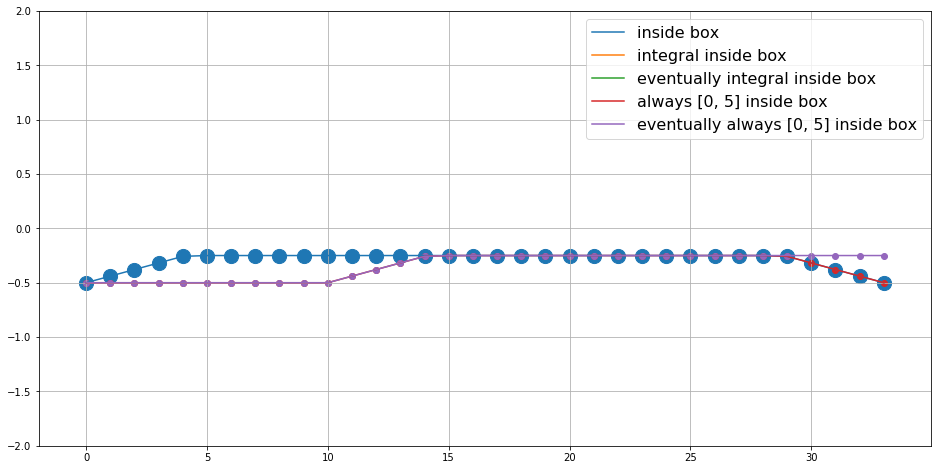

In [181]:
scale = -1
agm = False
plt.figure(figsize=(16, 8))
signal = inside_box_1(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), signal, label="inside box")
plt.scatter(range(len(signal)), signal, s=200)

integral = ϕ1.subformula(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), integral, label="integral inside box")
plt.scatter(range(len(signal)), integral)

rob = ϕ1(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), rob, label="eventually integral inside box")
plt.scatter(range(len(signal)), rob)

integral = ϕ2.subformula(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), integral, label="always [0, 5] inside box")
plt.scatter(range(len(signal)), integral)

rob = ϕ2(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), rob, label="eventually always [0, 5] inside box")
plt.scatter(range(len(signal)), rob)

plt.legend(fontsize=16)
plt.grid()
plt.ylim([-2, 2])


In [182]:
##### hyperparameters #####
γ = 0.3
lr = 0.05
margin = 0.125 # can add a margin so things are not right on the boundary
keepdim = True
scale = -1
agm = False
use_relu = False
###########################
fig_path = "experiments/integral/figs"
for _ in range(5000):
#     optimizer.zero_grad()
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
#     robustness_1 = torch.relu(-(ϕ1.robustness(box_inputs, scale=scale, keepdim=keepdim, agm=agm, use_relu=use_relu).squeeze() - margin) )
    robustness_1 = torch.relu(-(ϕ2.robustness(box_inputs, scale=scale, keepdim=keepdim, agm=agm).squeeze() - margin) )

    robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())

    robustness = robustness_1 + robustness_2

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(33):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue")
        plt.grid()
        plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_1: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_1.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))
        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.113   robustness_1: 0.375     robustness_2: 0.000     cont: 0.000000
100: loss: 0.091   robustness_1: 0.289     robustness_2: 0.000     cont: 0.004075
200: loss: 0.079   robustness_1: 0.237     robustness_2: 0.000     cont: 0.007411
300: loss: 0.070   robustness_1: 0.197     robustness_2: 0.000     cont: 0.010512
400: loss: 0.062   robustness_1: 0.162     robustness_2: 0.000     cont: 0.013491
500: loss: 0.055   robustness_1: 0.132     robustness_2: 0.000     cont: 0.014983
600: loss: 0.047   robustness_1: 0.100     robustness_2: 0.000     cont: 0.017184
700: loss: 0.041   robustness_1: 0.076     robustness_2: 0.000     cont: 0.018319
800: loss: 0.035   robustness_1: 0.051     robustness_2: 0.000     cont: 0.019367
900: loss: 0.029   robustness_1: 0.030     robustness_2: 0.000     cont: 0.019931
1000: loss: 0.023   robustness_1: 0.007     robustness_2: 0.000     cont: 0.020720
1100: loss: 0.019   robustness_1: 0.006     robustness_2: 0.000     cont: 0.017026
1200: loss: 0.01

In [177]:
data_path = "experiments/integral"

np.save(data_path + "/X_integral.npy", X.detach().numpy())
np.save(data_path + "/U_integral.npy", U.detach().numpy())

In [185]:
data_path = "experiments/integral"

np.save(data_path + "/X_always.npy", X.detach().numpy())
np.save(data_path + "/U_always.npy", U.detach().numpy())

In [186]:
x_integral = np.load(data_path + "/X_integral.npy")
x_always = np.load(data_path + "/X_always.npy")

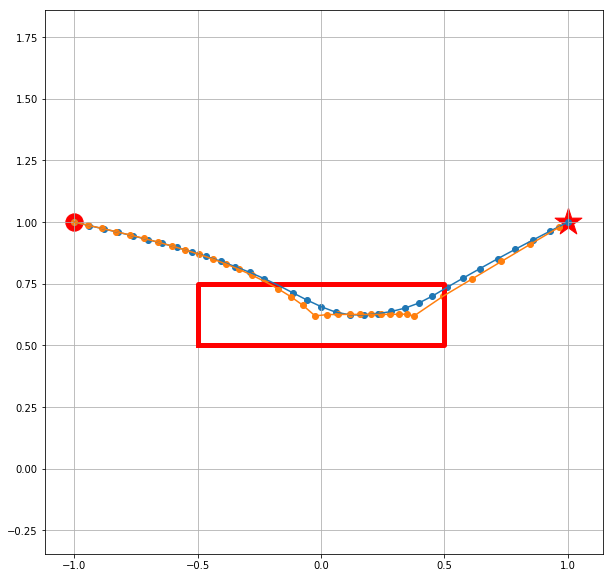

In [189]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="red")
plt.scatter(*xf, s=800, marker='*', c="red")

x = x_integral[:,0]
y = x_integral[:,1]
plt.plot(x, y)
plt.scatter(x, y)

x = x_always[:,0]
y = x_always[:,1]
plt.plot(x, y)
plt.scatter(x, y)

plt.axis("equal")
plt.grid()


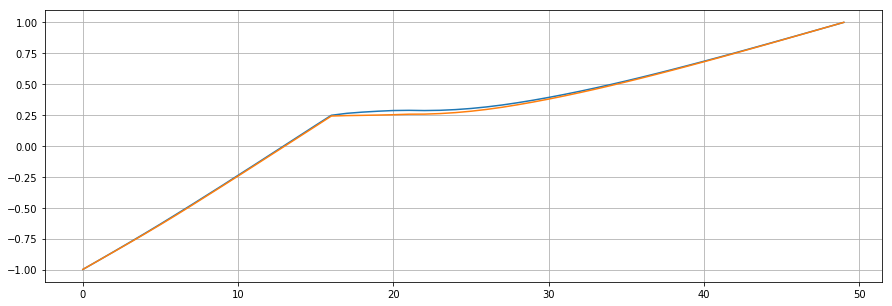

In [73]:
plt.figure(figsize=(15,5))

x = x_integral[:,0]
y = x_integral[:,1]
plt.plot(x)
# plt.scatter(x, y)

x = x_always[:,0]
y = x_always[:,1]
plt.plot(x)
# plt.scatter(x, y)
plt.grid()

In [123]:
def foo(a, **kwargs):
    return print(kwargs.keys())

In [124]:
k = {"g": 5}

In [125]:
foo(5, b = 5, **k)

dict_keys(['b', 'g'])
